<a href="https://colab.research.google.com/github/ju-mava/analisis-sentimiento-trabajo-final-p3/blob/main/A4_Machetti_Vallverd%C3%BA_J%C3%BAlia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook, utilizaremos diferentes tipos de redes neuronales para realizar el análisis de sentimiento del dataset de Sentiment140.

De este modo, para análisis de sentimiento, construïmos un modelo de aprendizaje profundo con varios tipos de RNNs y diversos parámetros. Nos quedamos con el mejor modelo, es decir, aquel que obtenga los mejores resultados en el conjunto de evaluación. Probar LIME con algunas instancias por cada categoría.

# Análisis, preprocesamiento y preparación de los datos

In [4]:
#Cargamos el dataset en CSV como un dataframe

sentiment140 = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

In [6]:
# Asignar nombres a las columnas
sentiment140.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# División en entrenamiento y temp (validación + test)
train_sentiment140, temp_sentiment140 = train_test_split(sentiment140, test_size=0.2, random_state=42, stratify=sentiment140['polarity'])

# División de temp en validación y test
val_sentiment140, test_sentiment140 = train_test_split(temp_sentiment140, test_size=0.5, random_state=42, stratify=temp_sentiment140['polarity'])

In [8]:
# Ahora tenemos tres conjuntos
print(f"Train: {len(train_sentiment140)} muestras")
print(f"Validación: {len(val_sentiment140)} muestras")
print(f"Test: {len(test_sentiment140)} muestras")

Train: 1280000 muestras
Validación: 160000 muestras
Test: 160000 muestras


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [10]:
df_list = []

for df_split, split_name in [(train_sentiment140, "train"), (val_sentiment140, "dev"), (test_sentiment140, "test")]:
    df_split = df_split.copy()
    df_split["split"] = split_name
    df_list.append(df_split)

df = pd.concat(df_list)
df.head()


,polarity,id,date,query,user,text,split
1036873,4,1956420446,Thu May 28 21:50:28 PDT 2009,NO_QUERY,captainsharmie,@paisleypaisley LOL why do i get ideas so far ...,train
287781,0,1994332739,Mon Jun 01 11:46:23 PDT 2009,NO_QUERY,sophiebridge,worst headache ever,train
333391,0,2013322139,Tue Jun 02 22:24:07 PDT 2009,NO_QUERY,hannahhwang,@ewaniesciuszko i am so sad i wont see you! I...,train
1484559,4,2067701853,Sun Jun 07 12:48:32 PDT 2009,NO_QUERY,LEE4NN,doesn't know how to spell conked,train
562778,0,2205745167,Wed Jun 17 05:21:39 PDT 2009,NO_QUERY,thesunmanager,&quot;So we stand here now and no one knows us...,train


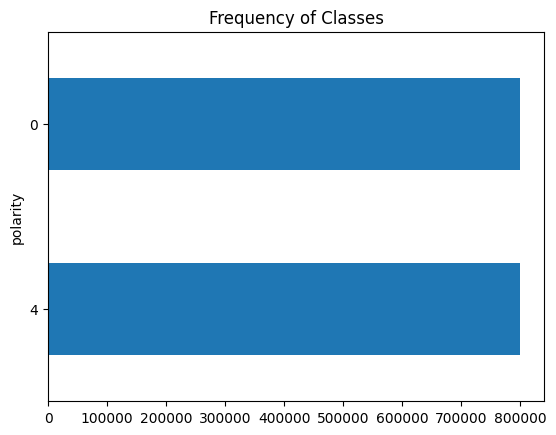

In [12]:
# Distribucion de instancias por clases (i.e. estrellas)

import matplotlib.pyplot as plt

df["polarity"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [13]:
# Nos quedamos con las columnas que nos interesan
df = df[['text', 'polarity', 'split']]
df

,text,polarity,split
1036873,@paisleypaisley LOL why do i get ideas so far ...,4,train
287781,worst headache ever,0,train
333391,@ewaniesciuszko i am so sad i wont see you! I...,0,train
1484559,doesn't know how to spell conked,4,train
562778,&quot;So we stand here now and no one knows us...,0,train
...,...,...,...
1519251,@iLikefatkids Awww. That's alright i guess. U...,4,test
883848,@blu3id Thanks,4,test
941934,"@kiiiiyoo i'm sorry kidd, yeah drink milky wil...",4,test
1107078,&quot;Zillow iPhone App: Using GPS to Compare ...,4,test


Vamos a dividir nuevamente el dataframe en tres, uno por split, aleatorizar los conjuntos de datos.

In [15]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'dev']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

,text,polarity,split
1424190,"Showerringgg , washing my goodieeess",4,train
323516,@CactusTri Trying to send you an invite but th...,0,train
463329,@monti4 no way ! why did u not call me straigh...,0,train
1181366,@ladygaga u rock i love your songs so much,4,train
1587255,has her music so loud its scaring the cat D: ...,4,train
...,...,...,...
218577,@selenagomez Press all day without JoJo what ...,0,train
1103915,@leah_bear indeed!,4,train
103518,@fderbaix Hard time accessing our Gmail mailbo...,0,train
785839,"had to go home from school today, too sick to ...",0,train


In [16]:
X_train = df_train['text']
X_valid = df_valid['text']
X_test = df_test['text']

X_train

,text
1424190,"Showerringgg , washing my goodieeess"
323516,@CactusTri Trying to send you an invite but th...
463329,@monti4 no way ! why did u not call me straigh...
1181366,@ladygaga u rock i love your songs so much
1587255,has her music so loud its scaring the cat D: ...
...,...
218577,@selenagomez Press all day without JoJo what ...
1103915,@leah_bear indeed!
103518,@fderbaix Hard time accessing our Gmail mailbo...
785839,"had to go home from school today, too sick to ..."


In [24]:
#0 refers to the negative and 1 to the positive
y_train = df_train['polarity'].map({0:0, 4:1}).values
y_valid = df_valid['polarity'].map({0:0, 4:1}).values
y_test = df_test['polarity'].map({0:0, 4:1}).values
y_train

array([1, 0, 0, ..., 0, 0, 1])

# Entrenamiento de redes neuronales

En estas líneas de código se está realizando el preprocesamiento de texto para poder utilizar los datos de texto en un modelo de redes neuronales.

Primero, se importa la clase Tokenizer de Keras. Esta clase proporciona una forma simple de preprocesar datos de texto para su uso en modelos de redes neuronales.

Luego, se crea una instancia de Tokenizer y se ajusta a los datos de entrenamiento con el método fit_on_texts. Esto construye un vocabulario de todas las palabras únicas en los datos de entrenamiento y asigna a cada palabra un índice entero único.

A continuación, se utiliza el método texts_to_sequences para convertir los datos de entrenamiento, validación y prueba en secuencias de índices de palabras. Cada palabra en el texto se reemplaza por el índice correspondiente del vocabulario construido anteriormente.

Una vez que se han convertido los datos de texto en secuencias de índices, se pueden utilizar como entrada para un modelo de redes neuronales. Sin embargo, tendremos que utilizar la función pad_sequences de Keras para asegurarnos de que todas las secuencias tengan la misma longitud antes de proporcionarlas como entrada al modelo.

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

**Tokenización y preprocesamiento**

Propósito: Convertir texto en representación numérica que la red neuronal pueda procesar.
Proceso:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

    Tokenizer():
        Crea un diccionario que asigna cada palabra única a un índice numérico.
        Ejemplo: {"el": 1, "servicio": 2, "excelente": 3, ...}.
    fit_on_texts(X_train):
        Analiza todos los textos de entrenamiento para construir el vocabulario.
        Solo se hace con los datos de entrenamiento para evitar "fugas" de información.


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq

[[196142, 2096, 5, 196143],
 [196144, 233, 2, 497, 7, 95, 1574, 18, 17, 535, 12, 3, 584, 8, 24, 176],
 [196145,
  36,
  130,
  113,
  125,
  53,
  24,
  329,
  14,
  1288,
  234,
  51,
  2,
  148,
  51764,
  106],
 [6861, 53, 619, 1, 46, 44, 688, 15, 90],
 [102, 107, 319, 15, 1569, 71, 7154, 3, 702, 387, 196146, 99, 142, 22, 10909],
 [51765, 7, 624, 1579, 3, 7953, 384, 70, 375, 11, 14],
 [20, 295, 95, 2036, 11, 6780, 3984, 168, 522, 9, 18, 9247, 351, 17720],
 [31,
  117,
  210,
  16,
  2,
  33,
  29,
  6,
  272,
  5,
  30,
  962,
  425,
  25434,
  999,
  12,
  408,
  27],
 [1,
  68,
  120342,
  102,
  101,
  196147,
  541,
  4,
  131,
  2618,
  351,
  9334,
  141,
  11573,
  29391,
  88,
  17,
  1178,
  46125],
 [51766, 1, 344, 452, 7781, 220],
 [934,
  21807,
  40,
  96,
  2436,
  32,
  21,
  5,
  1074,
  24381,
  27,
  45,
  10,
  3,
  97,
  36,
  164,
  492,
  11,
  14],
 [46126,
  167,
  1627,
  205,
  46127,
  587,
  151,
  202,
  452,
  18662,
  52,
  3,
  2550,
  400,
  8,
  20,

In [27]:
tokenizer.word_index

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'and': 6,
 'you': 7,
 'is': 8,
 'it': 9,
 'in': 10,
 'for': 11,
 'of': 12,
 'on': 13,
 'me': 14,
 'so': 15,
 'have': 16,
 'that': 17,
 'but': 18,
 "i'm": 19,
 'just': 20,
 'with': 21,
 'be': 22,
 'at': 23,
 'not': 24,
 'was': 25,
 'this': 26,
 'now': 27,
 'good': 28,
 'up': 29,
 'day': 30,
 'all': 31,
 'out': 32,
 'get': 33,
 'like': 34,
 'are': 35,
 'no': 36,
 'go': 37,
 'quot': 38,
 'http': 39,
 'today': 40,
 'do': 41,
 "it's": 42,
 'too': 43,
 'your': 44,
 'work': 45,
 'love': 46,
 'going': 47,
 'got': 48,
 'lol': 49,
 'time': 50,
 'back': 51,
 'from': 52,
 'u': 53,
 'what': 54,
 'one': 55,
 'will': 56,
 'com': 57,
 'im': 58,
 'know': 59,
 'we': 60,
 'about': 61,
 'really': 62,
 'am': 63,
 "don't": 64,
 'amp': 65,
 'had': 66,
 'can': 67,
 'see': 68,
 "can't": 69,
 'some': 70,
 'its': 71,
 'if': 72,
 'still': 73,
 '2': 74,
 'well': 75,
 'night': 76,
 'new': 77,
 'want': 78,
 'how': 79,
 'think': 80,
 'home': 81,
 'thanks': 82,
 'oh': 

**Creación de secuencias y padding**

Estas líneas de código se utilizan para asegurar que todas las secuencias de texto tengan la misma longitud. Esto es necesario porque muchos modelos de redes neuronales requieren que la entrada tenga un tamaño fijo.

Primero, se calcula el tamaño del vocabulario a partir del objeto tokenizer creado anteriormente. Esto se hace sumando 1 al número de palabras únicas en el vocabulario, ya que el índice 0 se reserva para un token especial que se utiliza para rellenar las secuencias más cortas.

Luego, se establece la longitud máxima de las secuencias en 120. Esto significa que todas las secuencias se cortarán o rellenarán hasta tener una longitud de 120 tokens.

Finalmente, se utiliza la función pad_sequences de Keras para rellenar o cortar las secuencias de entrenamiento, validación y prueba hasta tener una longitud de 120. La opción padding='post' indica que el relleno se debe añadir al final de la secuencia. Si se elige padding='pre', el relleno se añadirá al principio de la secuencia.

In [28]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 120

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_valid_pad = pad_sequences(X_valid_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

X_train_pad

array([[196142,   2096,      5, ...,      0,      0,      0],
       [196144,    233,      2, ...,      0,      0,      0],
       [196145,     36,    130, ...,      0,      0,      0],
       ...,
       [595000,    298,     50, ...,      0,      0,      0],
       [    66,      2,     37, ...,      0,      0,      0],
       [ 36130,     54,    501, ...,      0,      0,      0]], dtype=int32)

## Red neuronal RNN básica con pooling: comparación embeddings 100/200/300

**Con embeddings de 100 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 100                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [40]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - accuracy: 0.6533 - loss: 0.6373 - val_accuracy: 0.6674 - val_loss: 0.6225
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.7030 - loss: 0.6038 - val_accuracy: 0.6628 - val_loss: 0.6068
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.7389 - loss: 0.5301 - val_accuracy: 0.7643 - val_loss: 0.5074
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.8359 - loss: 0.3931 - val_accuracy: 0.7961 - val_loss: 0.4772
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.8637 - loss: 0.3271 - val_accuracy: 0.7951 - val_loss: 0.4641


In [41]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7945 - loss: 0.4651

Precisión en test: 0.7946


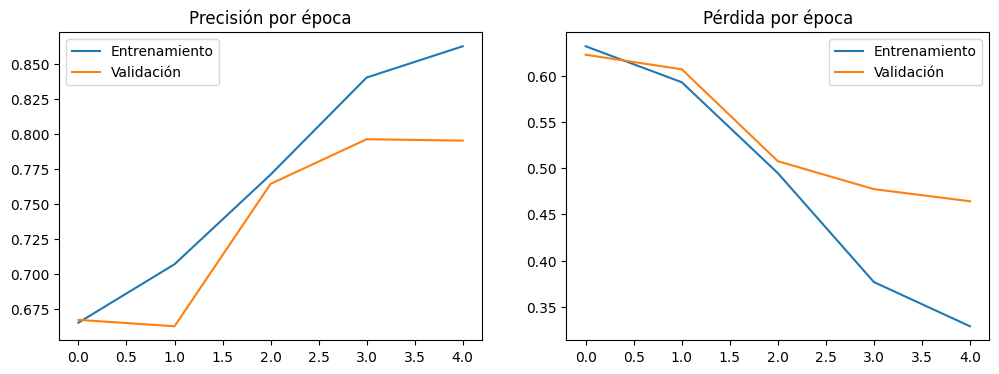

In [42]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


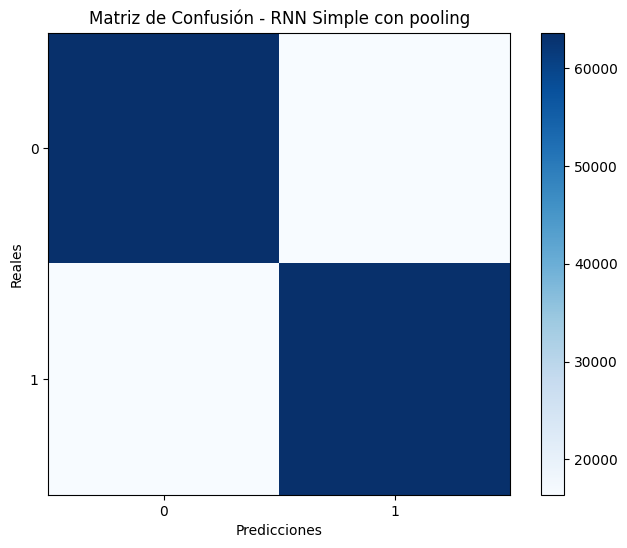

In [44]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [46]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.79      0.80      0.79     80000
  1:positive       0.79      0.79      0.79     80000

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



**Con embeddings de 200 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 200                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 119000200 elements. This may consume a large amount of memory.
  warnings.warn(


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 127s 47ms/step - accuracy: 0.6586 - loss: 0.6351 - val_accuracy: 0.7433 - val_loss: 0.5342
Epoch 2/5
1982/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.7921 - loss: 0.4842

In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7945 - loss: 0.4651

Precisión en test: 0.7946


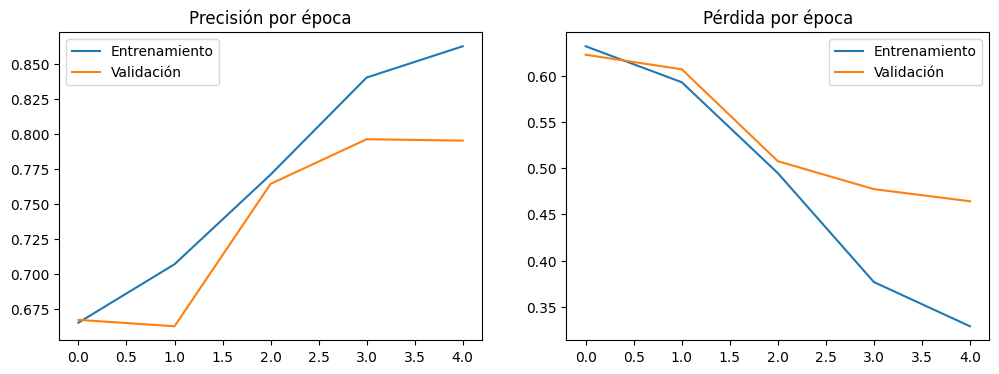

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


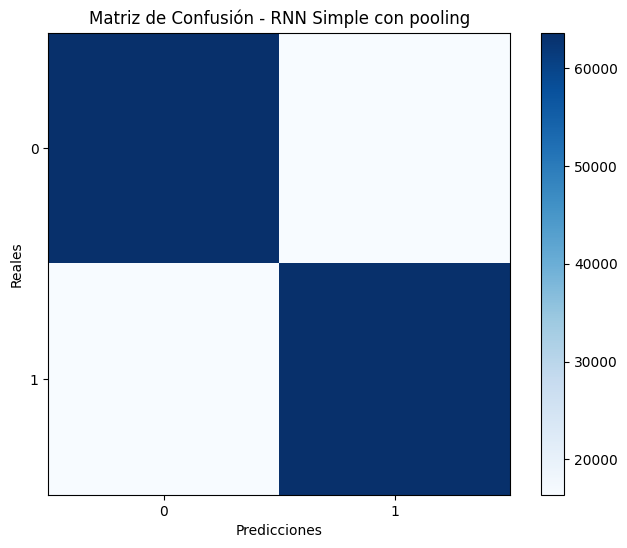

In [ ]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.79      0.80      0.79     80000
  1:positive       0.79      0.79      0.79     80000

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



**Con embeddings de 300 dimensiones**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GlobalAveragePooling1D, Dense


# Modelo simplificado con pooling para clasificación de sentimientos
# Parámetros de ejemplo
vocab_size = len(tokenizer.word_index) + 1   # Tamaño del vocabulario
embedding_dim = 300                          # Dimensión de los embeddings

model_pool = Sequential([
    # Capa de Embedding: Representa cada palabra en un espacio vectorial.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen,
              trainable=True),

    # Capa RNN: Procesa la secuencia completa y devuelve todos los estados ocultos.
    # Esto permite aplicar pooling a lo largo de la secuencia.
    SimpleRNN(128, return_sequences=True),

    # Pooling: Calcula la media de los estados ocultos para obtener una representación global.
    GlobalAveragePooling1D(),

    # Capa de Clasificación: Toma la representación agregada y asigna probabilidades a cada clase.
    Dense(1, activation='sigmoid')
])

model_pool.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_pool.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento.

In [ ]:
# Entrenamiento con early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_pool.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=512, # se recomiendo batches de menor tamaño para mejor rendimiento (pero entrenamiento toma más tiempo)
                    validation_data=(X_valid_pad, y_valid),
                    callbacks=[early_stop])

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - accuracy: 0.6533 - loss: 0.6373 - val_accuracy: 0.6674 - val_loss: 0.6225
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.7030 - loss: 0.6038 - val_accuracy: 0.6628 - val_loss: 0.6068
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.7389 - loss: 0.5301 - val_accuracy: 0.7643 - val_loss: 0.5074
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.8359 - loss: 0.3931 - val_accuracy: 0.7961 - val_loss: 0.4772
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.8637 - loss: 0.3271 - val_accuracy: 0.7951 - val_loss: 0.4641


In [ ]:
# Evaluación del modelo
test_loss, test_acc = model_pool.evaluate(X_test_pad, y_test)
print(f"\nPrecisión en test: {test_acc:.4f}")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7945 - loss: 0.4651

Precisión en test: 0.7946


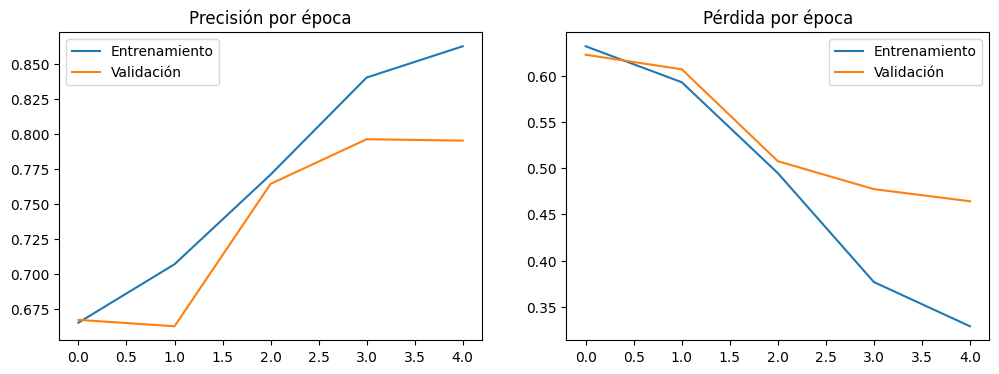

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.legend()
plt.show()

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


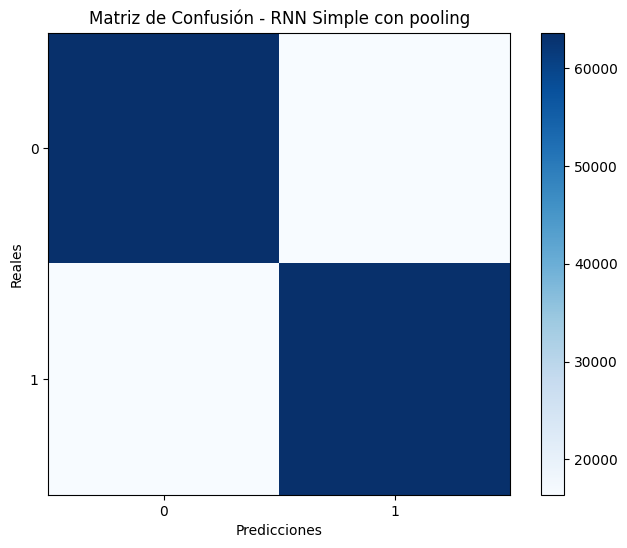

In [ ]:
# Predicción binaria: salida de sigmoid
y_pred = (model_pool.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.yticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de Confusión - RNN Simple con pooling')
plt.show()

In [ ]:
# Análisis de errores frecuentes
print(classification_report(y_test, y_pred, target_names=['0:negative', '1:positive']))

              precision    recall  f1-score   support

  0:negative       0.79      0.80      0.79     80000
  1:positive       0.79      0.79      0.79     80000

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



**Nos quedamos con los embeddings de 300 dimensiones para el resto de los modelos, ya que son los que mejores resultados nos han dado hasta ahora.**

## Red neuronal RNN básica con pooling y embeddings de 300 dimensiones: comparación 64, 128 y 256 neuronas

**Con 128 neuronas**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Con 64 neuronas**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Con 256 neuronas**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Nos quedamos con las 128 neuronas y los embeddings de 300 dimensiones para el resto de los modelos, ya que son los que mejores resultados nos han dado hasta ahora.**

## Red neuronal RNN básica con pooling, 128 neuronas y embeddings de 300 dimensiones: comparación de 5, 10, 20 y 50 epochs

**Con 5 epochs (patience 3)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Con 10 epochs (patience 3)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Con 20 epochs (patience 5)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Con 50 epochs (patience 10)**

Esta alternativa recoge todos los estados ocultos generados para cada token y aplica una operación de pooling para obtener una representación global del texto. Aquí se muestra el ejemplo usando pooling de media, aunque se puede usar también el pooling máximo.

**Nos quedamos con las 128 neuronas, los embeddings de 300 dimensiones y los 50 epochs con patience 10 para el resto de los modelos, ya que son los que mejores resultados nos han dado hasta ahora. De hecho, conseguimos una f1-score de 0.50 tanto para accuracy como para macro avg y weighted avg. Este es el mejor resultado que hemos obtenido de todas las combinaciones que hemos probado.**

Para probar distintas combinaciones de parámetros, he seguido una metodología sistemática y coherente comprobando primero las variaciones de uno solo parámetro para así quedarme con la opción que mejores resultados ofrece. Definido así el primer parámetro, podemos pasar al siguiente y probar también todas sus opciones manteniendo estable el primer parámetro seleccionado para todas ellas, y así sucesivamente, hasta que todos hayan quedado definidos.  

Durante el proceso de entrenamiento del modelo con una red neuronal básica con pooling, he evaluado distintas configuraciones para encontrar la combinación óptima teniendo en cuenta los siguientes factores: dimensión de los embeddings, número de neuronas en la capa oculta y número de épocas (con la patience correspondiente). Después del experimento nos quedamos con las 128 neuronas, los embeddings de 300 dimensiones y los 50 epochs con patience 10, ya que son los que mejores resultados nos han dado hasta ahora. De hecho, conseguimos una f1-score de 0.50 tanto para accuracy como para macro avg y weighted avg. Este es el mejor resultado que hemos obtenido de todas las combinaciones que hemos probado.

**Dimensión de los embeddings**: He probado con vectores de embeddings de 100, 200 y 300 dimensiones. El modelo con embeddings de 300 dimensiones es el que ha obtenido el mejor rendimiento general. Esto puede explicarse porque los embeddings de mayor dimensión permiten una representación semántica más rica de las palabras, capturando matices más complejos del lenguaje. Aunque los embeddings de menor dimensión son más eficientes computacionalmente, en este caso la mejora en la precisión justifica el coste computacional mayor en el que incurrimos.

**Número de neuronas en la capa oculta**: Una vez fijado el tamaño óptimo de los embeddings (300 dimensiones), he probado de adaptar la capacidad del modelo variando el número de neuronas en la capa densa (64, 128 y 256). El mejor rendimiento lo he conseguido con 128 neuronas, que, al ser la opción intermedia, equilibra la capacidad de aprendizaje y el riesgo de sobreajuste. Con 64 neuronas, el modelo probablemente no disponía de suficiente capacidad para aprender patrones complejos; mientras que con 256 neuronas, no hubo una mejora significativa debido al sobreajuste.

**Número de épocas de entrenamiento**: Por último, he experimentado con distintas duraciones del entrenamiento (5, 10, 20 y 50 épocas). Cabe comentar que la variación en la cantidad de epochs no ha modificado prácticamente nada los resultados. De todas formas, debemos tener en cuenta que siempre hemos adaptado la patience proporcionalmente a la cantidad de epochs seleccionada, pudiendo ser este un aspecto que ha incidido en los resultados. En conclusión, esto justificaría que no hayamos observado diferencias significativas en el rendimiento final. De hecho, esto permite que el modelo deje de entrenar una vez alcanzada la convergencia, independientemente del máximo de épocas establecido. Este comportamiento indica que el modelo converge rápidamente y que extender las épocas más allá de un cierto punto no aporta más beneficios.